#Student Name: Vipul Popat
#Student ID: 18195121

Dataset : https://archive.ics.uci.edu/ml/datasets/Autism+Screening+Adult

It's not intended to be the most accurate Autism detection model out there, but to explain how to create, visualise and understand Classification Trees. 




In [1]:
# Imports needed for the script
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont



In [2]:
# Loading the data
data = pd.read_csv('autism_data.csv', header=None, names=['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','age','gender','ethnicity','born_with_jaundice','family_mem_with_pdd','country_of_residence','used_scr_app_before','screening_result','age_desc','relation','class_asd'], dtype={'ethnicity':str})
data.replace('?', np.nan, inplace=True)
null_counts = data.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
A1                       0
A2                       0
A3                       0
A4                       0
A5                       0
A6                       0
A7                       0
A8                       0
A9                       0
A10                      0
age                      2
gender                   0
ethnicity               95
born_with_jaundice       0
family_mem_with_pdd      0
country_of_residence     0
used_scr_app_before      0
screening_result         0
age_desc                 0
relation                95
class_asd                0
dtype: int64


In [3]:
print(data.columns.tolist())
data.head(5)

['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'age', 'gender', 'ethnicity', 'born_with_jaundice', 'family_mem_with_pdd', 'country_of_residence', 'used_scr_app_before', 'screening_result', 'age_desc', 'relation', 'class_asd']


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,gender,ethnicity,born_with_jaundice,family_mem_with_pdd,country_of_residence,used_scr_app_before,screening_result,age_desc,relation,class_asd
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,'United States',no,6,'18 and more',Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5,'18 and more',Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8,'18 and more',Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,'United States',no,6,'18 and more',Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,NaN,no,no,Egypt,no,2,'18 and more',NaN,NO


In [4]:
# making a copy of the train data set for future use
original_data = data.copy()

In [5]:
# Getting a range of data with unique values and count for each column
for col in data.columns:
    print(data[col].value_counts())

1    508
0    196
Name: A1, dtype: int64
0    385
1    319
Name: A2, dtype: int64
0    382
1    322
Name: A3, dtype: int64
0    355
1    349
Name: A4, dtype: int64
0    353
1    351
Name: A5, dtype: int64
0    504
1    200
Name: A6, dtype: int64
0    410
1    294
Name: A7, dtype: int64
1    457
0    247
Name: A8, dtype: int64
0    476
1    228
Name: A9, dtype: int64
1    404
0    300
Name: A10, dtype: int64
21     49
20     46
23     37
22     37
19     35
24     34
27     31
18     31
30     30
26     28
25     27
29     27
28     24
31     21
17     18
32     18
37     17
35     17
33     16
40     16
42     15
36     13
34     12
38     12
43     11
44     10
47      8
39      7
53      6
46      6
55      6
52      5
50      5
45      4
48      4
49      3
41      3
56      2
61      2
58      2
54      2
383     1
51      1
60      1
59      1
64      1
Name: age, dtype: int64
m    367
f    337
Name: gender, dtype: int64
White-European       233
Asian                123
'Middle Ea

In [6]:
#mapping of relevant entries
ethnicity_mapping = {"'Middle Eastern '": 1, "'South Asian'": 2, "Others": 3, "Asian": 4, "Black": 5, "Hispanic": 6, "Latino": 7, "Pasifika": 8, "Turkish": 9, "White-European": 10}
data.ethnicity = data.ethnicity.replace(['others',np.nan],'Others')
data.ethnicity = data.ethnicity.replace(ethnicity_mapping)

gender_mapping = {"f" : 1, "m" : 0}
data.gender = data.gender.replace(gender_mapping)

#print(data.dtypes)
#data.age.isnull().replace(np.nan, data.age.mean(), inplace=True)

jaundince_mapping = {"yes" : 1, "no" : 0}
data.born_with_jaundice = data.born_with_jaundice.replace(jaundince_mapping)

family_mem_with_pdd_mapping = {"yes" : 1, "no" : 0}
data.family_mem_with_pdd = data.family_mem_with_pdd.replace(family_mem_with_pdd_mapping)

class_asd_mapping = {"YES" : 1, "NO" : 0}
data.class_asd = data.class_asd.replace(class_asd_mapping)





In [7]:
# Feature selection: remove variables no longer containing relevant information
# Personally I do not think these variables would make any different to the result
drop_columns = ['country_of_residence', 'used_scr_app_before', 'screening_result', 'age_desc', 'relation']
data = data.drop(drop_columns, axis=1)
print(len(data.columns))

# TODO dropping samples with nan
data = data.dropna()
train, test = train_test_split(data, test_size=0.2)
train.isna().sum()

16


A1                     0
A2                     0
A3                     0
A4                     0
A5                     0
A6                     0
A7                     0
A8                     0
A9                     0
A10                    0
age                    0
gender                 0
ethnicity              0
born_with_jaundice     0
family_mem_with_pdd    0
class_asd              0
dtype: int64

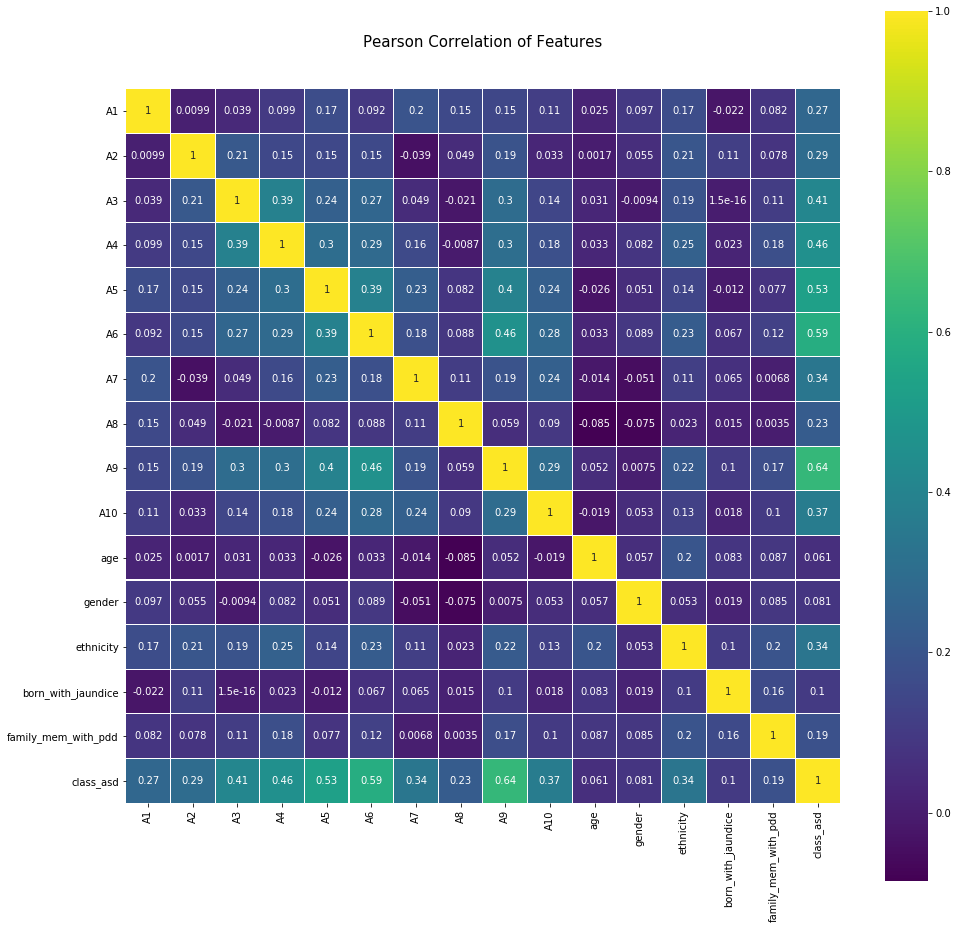

In [8]:
colormap = plt.cm.viridis
plt.figure(figsize=(16,16))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

This heatmap is very useful as an initial observation because you can easily get an idea of the predictive value of each feature. In this case, A9 & A6 show the highest correlations (in absolute terms) with the class (ASD): 0.62 and 0.6 respectively. High chances are one of them will be used for the first node in our final decision tree, so let's first explore further these features and compare them.

***Gini Impurity***

Before start working with Decision Trees, let's briefly explain how they work. The goal of their learning algorithms is always to find the best split for each node of the tree. But measuring the "goodness" of a given split is a subjective question so, in practice, different metrics are used for evaluating splits. One commonly used metric is Information Gain. The sklearn library we're gonna use implements Gini Impurity, another common measure, so let’s explain it.

Gini Impurity measures the disorder of a set of elements. It is calculated as the probability of mislabelling an element assuming that the element is randomly labelled according the the distribution of all the classes in the set. Decision Trees will try to find the split which decreases Gini Impurity the most across the two resulting nodes. For the autism dataset example it can be calculated as follows (code should be explicit enough):

In [9]:
# Define function to calculate Gini Impurity
def get_gini_impurity(asd_positive_count, total_count):
    asd_prob = asd_positive_count/total_count
    not_asd_prob = (1 - asd_prob)
    random_observation_asd_prob = asd_prob
    random_observation_not_asd_prob = (1 - random_observation_asd_prob)
    mislabelling_asd_prob = not_asd_prob * random_observation_asd_prob
    mislabelling_not_asd_prob = asd_prob * random_observation_not_asd_prob
    gini_impurity = mislabelling_asd_prob + mislabelling_not_asd_prob
    return gini_impurity

In [10]:
train.class_asd.value_counts()

0    419
1    142
Name: class_asd, dtype: int64

In [11]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(151, 561)
gini_impurity_starting_node

0.3934278297285532

In [12]:
cv = KFold(n_splits=4)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

#print(train.to_string())
#print(test.to_string())

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        print("Train fold=", train_fold)
        print("Valid fold=", valid_fold)
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices
        print("Train fold=", f_train)
        print("Valid fold=", f_valid)


Current max depth:  1 

Train fold= [141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248
 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266
 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284
 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320
 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374
 375 376 377 37

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
141  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   29     0.0        2.0   
142  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   25     0.0        4.0   
143  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   27     0.0        4.0   
144  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   22     0.0        2.0   
145  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
146  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   20     0.0       10.0   
147  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   19     1.0       10.0   
148  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0   37     1.0        3.0   
149  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0   35     0.0       10.0   
150  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
151  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
152  1.0  1.0  

Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
0    1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   26     1.0       10.0   
1    1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   24     0.0        7.0   
2    1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   27     0.0        7.0   
3    1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0   35     1.0       10.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   40     1.0        3.0   
5    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   36     0.0        3.0   
6    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   17     1.0        5.0   
7    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
8    1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0   29     0.0       10.0   
9    1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   17     0.0        4.0   
10   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   33     0.0       10.0   
11   0.0  1.0  0

Train fold= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 281 282 283
 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301
 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319
 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355
 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 374 375 376 377 378 379 380 381 382 38

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
281  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
282  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
283  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   44     1.0       10.0   
284  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   47     1.0       10.0   
285  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0   32     1.0        3.0   
286  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   40     0.0       10.0   
287  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
288  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   44     1.0       10.0   
289  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   56     0.0       10.0   
290  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   23     1.0       10.0   
291  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   32     1.0        5.0   
292  0.0  1.0  1

Valid fold= [141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248
 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266
 267 268 269 270 271 272 273 274 275 276 277 278 279 280]
Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
0    1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   26     1.0       10.0   
1    1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   24     0.0        7.0   
2    1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   27     0.0        7.0   
3    1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0   35     1.0       10.0   
4 

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
281  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
282  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
283  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   44     1.0       10.0   
284  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   47     1.0       10.0   
285  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0   32     1.0        3.0   
286  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   40     0.0       10.0   
287  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
288  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   44     1.0       10.0   
289  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   56     0.0       10.0   
290  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   23     1.0       10.0   
291  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   32     1.0        5.0   
292  0.0  1.0  1

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
0    1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   26     1.0       10.0   
1    1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   24     0.0        7.0   
2    1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   27     0.0        7.0   
3    1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0   35     1.0       10.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   40     1.0        3.0   
5    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   36     0.0        3.0   
6    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   17     1.0        5.0   
7    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
8    1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0   29     0.0       10.0   
9    1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   17     0.0        4.0   
10   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   33     0.0       10.0   
11   0.0  1.0  0

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
281  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
282  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
283  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   44     1.0       10.0   
284  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   47     1.0       10.0   
285  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0   32     1.0        3.0   
286  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   40     0.0       10.0   
287  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
288  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   44     1.0       10.0   
289  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   56     0.0       10.0   
290  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   23     1.0       10.0   
291  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   32     1.0        5.0   
292  0.0  1.0  1

Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
141  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   29     0.0        2.0   
142  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   25     0.0        4.0   
143  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   27     0.0        4.0   
144  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   22     0.0        2.0   
145  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
146  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   20     0.0       10.0   
147  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   19     1.0       10.0   
148  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0   37     1.0        3.0   
149  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0   35     0.0       10.0   
150  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
151  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
152  1.0  1.0  0

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
141  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   29     0.0        2.0   
142  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   25     0.0        4.0   
143  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   27     0.0        4.0   
144  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   22     0.0        2.0   
145  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
146  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   20     0.0       10.0   
147  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   19     1.0       10.0   
148  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0   37     1.0        3.0   
149  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0   35     0.0       10.0   
150  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
151  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
152  1.0  1.0  0

[421 rows x 16 columns]
Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
421  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   27     0.0        1.0   
422  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   23     1.0        1.0   
423  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
424  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
425  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
426  1.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0   24     0.0        4.0   
427  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   21     0.0        3.0   
428  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0   20     1.0        3.0   
429  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0   20     0.0        3.0   
430  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
431  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   61     0.0       

Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
0    1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   26     1.0       10.0   
1    1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   24     0.0        7.0   
2    1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   27     0.0        7.0   
3    1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0   35     1.0       10.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   40     1.0        3.0   
5    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   36     0.0        3.0   
6    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   17     1.0        5.0   
7    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
8    1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0   29     0.0       10.0   
9    1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   17     0.0        4.0   
10   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   33     0.0       10.0   
11   0.0  1.0  0

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
281  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
282  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
283  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   44     1.0       10.0   
284  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   47     1.0       10.0   
285  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0   32     1.0        3.0   
286  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   40     0.0       10.0   
287  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
288  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   44     1.0       10.0   
289  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   56     0.0       10.0   
290  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   23     1.0       10.0   
291  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   32     1.0        5.0   
292  0.0  1.0  1

Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
141  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   29     0.0        2.0   
142  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   25     0.0        4.0   
143  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   27     0.0        4.0   
144  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   22     0.0        2.0   
145  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
146  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   20     0.0       10.0   
147  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   19     1.0       10.0   
148  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0   37     1.0        3.0   
149  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0   35     0.0       10.0   
150  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
151  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
152  1.0  1.0  0

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
141  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   29     0.0        2.0   
142  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   25     0.0        4.0   
143  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   27     0.0        4.0   
144  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   22     0.0        2.0   
145  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
146  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   20     0.0       10.0   
147  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   19     1.0       10.0   
148  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0   37     1.0        3.0   
149  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0   35     0.0       10.0   
150  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
151  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
152  1.0  1.0  0

Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
0    1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   26     1.0       10.0   
1    1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   24     0.0        7.0   
2    1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   27     0.0        7.0   
3    1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0   35     1.0       10.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   40     1.0        3.0   
5    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   36     0.0        3.0   
6    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   17     1.0        5.0   
7    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
8    1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0   29     0.0       10.0   
9    1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   17     0.0        4.0   
10   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   33     0.0       10.0   
11   0.0  1.0  0

Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
0    1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   26     1.0       10.0   
1    1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   24     0.0        7.0   
2    1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   27     0.0        7.0   
3    1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0   35     1.0       10.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   40     1.0        3.0   
5    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   36     0.0        3.0   
6    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   17     1.0        5.0   
7    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
8    1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0   29     0.0       10.0   
9    1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   17     0.0        4.0   
10   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   33     0.0       10.0   
11   0.0  1.0  0

Train fold= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 24

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
0    1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   26     1.0       10.0   
1    1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   24     0.0        7.0   
2    1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   27     0.0        7.0   
3    1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0   35     1.0       10.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   40     1.0        3.0   
5    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   36     0.0        3.0   
6    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   17     1.0        5.0   
7    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
8    1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0   29     0.0       10.0   
9    1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   17     0.0        4.0   
10   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   33     0.0       10.0   
11   0.0  1.0  0

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
281  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
282  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
283  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   44     1.0       10.0   
284  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   47     1.0       10.0   
285  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0   32     1.0        3.0   
286  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   40     0.0       10.0   
287  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
288  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   44     1.0       10.0   
289  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   56     0.0       10.0   
290  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   23     1.0       10.0   
291  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   32     1.0        5.0   
292  0.0  1.0  1

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
0    1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   26     1.0       10.0   
1    1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   24     0.0        7.0   
2    1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   27     0.0        7.0   
3    1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0   35     1.0       10.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   40     1.0        3.0   
5    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   36     0.0        3.0   
6    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   17     1.0        5.0   
7    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
8    1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0   29     0.0       10.0   
9    1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   17     0.0        4.0   
10   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   33     0.0       10.0   
11   0.0  1.0  0

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
281  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
282  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
283  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   44     1.0       10.0   
284  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   47     1.0       10.0   
285  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0   32     1.0        3.0   
286  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   40     0.0       10.0   
287  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
288  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   44     1.0       10.0   
289  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   56     0.0       10.0   
290  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   23     1.0       10.0   
291  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   32     1.0        5.0   
292  0.0  1.0  1

Train fold= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 281 282 283
 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301
 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319
 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355
 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 374 375 376 377 378 379 380 381 382 38

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
421  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   27     0.0        1.0   
422  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   23     1.0        1.0   
423  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
424  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
425  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
426  1.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0   24     0.0        4.0   
427  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   21     0.0        3.0   
428  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0   20     1.0        3.0   
429  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0   20     0.0        3.0   
430  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
431  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   61     0.0       10.0   
432  1.0  0.0  0

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
141  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   29     0.0        2.0   
142  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   25     0.0        4.0   
143  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   27     0.0        4.0   
144  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   22     0.0        2.0   
145  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
146  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   20     0.0       10.0   
147  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   19     1.0       10.0   
148  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0   37     1.0        3.0   
149  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0   35     0.0       10.0   
150  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
151  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
152  1.0  1.0  0

Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
141  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   29     0.0        2.0   
142  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   25     0.0        4.0   
143  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   27     0.0        4.0   
144  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   22     0.0        2.0   
145  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
146  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   20     0.0       10.0   
147  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   19     1.0       10.0   
148  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0   37     1.0        3.0   
149  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0   35     0.0       10.0   
150  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
151  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
152  1.0  1.0  0

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
281  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
282  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
283  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   44     1.0       10.0   
284  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   47     1.0       10.0   
285  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0   32     1.0        3.0   
286  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   40     0.0       10.0   
287  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
288  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   44     1.0       10.0   
289  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   56     0.0       10.0   
290  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   23     1.0       10.0   
291  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   32     1.0        5.0   
292  0.0  1.0  1

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
421  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   27     0.0        1.0   
422  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   23     1.0        1.0   
423  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
424  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
425  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
426  1.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0   24     0.0        4.0   
427  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   21     0.0        3.0   
428  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0   20     1.0        3.0   
429  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0   20     0.0        3.0   
430  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
431  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   61     0.0       10.0   
432  1.0  0.0  0

Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
0    1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   26     1.0       10.0   
1    1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   24     0.0        7.0   
2    1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   27     0.0        7.0   
3    1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0   35     1.0       10.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   40     1.0        3.0   
5    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   36     0.0        3.0   
6    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   17     1.0        5.0   
7    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
8    1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0   29     0.0       10.0   
9    1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   17     0.0        4.0   
10   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   33     0.0       10.0   
11   0.0  1.0  0

[421 rows x 16 columns]
Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
281  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
282  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
283  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   44     1.0       10.0   
284  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   47     1.0       10.0   
285  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0   32     1.0        3.0   
286  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   40     0.0       10.0   
287  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
288  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   44     1.0       10.0   
289  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   56     0.0       10.0   
290  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   23     1.0       10.0   
291  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   32     1.0       

Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
141  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   29     0.0        2.0   
142  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   25     0.0        4.0   
143  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   27     0.0        4.0   
144  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   22     0.0        2.0   
145  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
146  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   20     0.0       10.0   
147  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   19     1.0       10.0   
148  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0   37     1.0        3.0   
149  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0   35     0.0       10.0   
150  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
151  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
152  1.0  1.0  0

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
141  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   29     0.0        2.0   
142  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   25     0.0        4.0   
143  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0   27     0.0        4.0   
144  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   22     0.0        2.0   
145  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
146  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   20     0.0       10.0   
147  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   19     1.0       10.0   
148  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0   37     1.0        3.0   
149  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0   35     0.0       10.0   
150  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
151  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
152  1.0  1.0  0

Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
0    1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   26     1.0       10.0   
1    1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   24     0.0        7.0   
2    1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   27     0.0        7.0   
3    1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0   35     1.0       10.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   40     1.0        3.0   
5    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   36     0.0        3.0   
6    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   17     1.0        5.0   
7    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
8    1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0   29     0.0       10.0   
9    1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   17     0.0        4.0   
10   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   33     0.0       10.0   
11   0.0  1.0  0

[141 rows x 16 columns]
Train fold= [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 281 282 283
 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301
 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319
 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355
 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 374 375 376 37

Train fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
0    1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   26     1.0       10.0   
1    1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0   24     0.0        7.0   
2    1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   27     0.0        7.0   
3    1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0   35     1.0       10.0   
4    1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   40     1.0        3.0   
5    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0   36     0.0        3.0   
6    0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   17     1.0        5.0   
7    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
8    1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0   29     0.0       10.0   
9    1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   17     0.0        4.0   
10   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   33     0.0       10.0   
11   0.0  1.0  0

Valid fold=       A1   A2   A3   A4   A5   A6   A7   A8   A9  A10  age  gender  ethnicity  \
421  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   27     0.0        1.0   
422  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   23     1.0        1.0   
423  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
424  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
425  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
426  1.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0   24     0.0        4.0   
427  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   21     0.0        3.0   
428  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0   20     1.0        3.0   
429  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0   20     0.0        3.0   
430  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN        NaN   
431  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   61     0.0       10.0   
432  1.0  0.0  0